In [1]:
# %pip install numpy
# %pip install scikit-learn
# %pip install kagglehub
# %pip install matplotlib
# %pip install qiskit
# %pip install qiskit_machine_learning
# %pip install 'qiskit[visualization]'
# %pip install qiskit_ibm_runtime

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from qiskit.circuit import QuantumCircuit, ParameterVector
from sklearn.decomposition import PCA
from qiskit_machine_learning.algorithms import QSVC
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms.quantum_kernel_trainer import QuantumKernelTrainer
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
import kagglehub

#### Download dataset

In [2]:
path = kagglehub.dataset_download("aswathrao/demand-forecasting")

# print("Path to dataset files:", path)

#### Read the data

In [3]:
train_data = pd.read_csv(f'{path}/train_0irEZ2H.csv')
test_data = pd.read_csv(f'{path}/test_nfaJ3J5.csv')
sample_submission = pd.read_csv(f'{path}/sample_submission_pzljTaX.csv')

#### Convert 'week' to datetime format

In [4]:
train_data['week'] = pd.to_datetime(train_data['week'], format='%d/%m/%y')
test_data['week'] = pd.to_datetime(test_data['week'], format='%d/%m/%y')

#### Create the Demand Class column based on the median threshold of 'units_sold'

In [5]:
threshold = train_data['units_sold'].median()
train_data['Demand Class'] = (train_data['units_sold'] > threshold).astype(int)

#### Remove rows with NaN values from both train_data and test_data

In [6]:
train_data_cleaned = train_data.dropna(subset=['total_price', 'base_price', 'is_featured_sku', 'is_display_sku', 'Demand Class'])
test_data_cleaned = test_data.dropna(subset=['total_price', 'base_price', 'is_featured_sku', 'is_display_sku'])
sample_submission_cleaned = sample_submission.dropna(subset=['units_sold'])

#### Check the data

In [7]:
train_data_cleaned.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,Demand Class
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,0
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,0
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,0
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,1
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,1


#### Prepare feature matrices and target vectors

In [8]:
X_train = train_data_cleaned[['total_price', 'base_price', 'is_featured_sku', 'is_display_sku']].values
y_train = train_data_cleaned['Demand Class'].values
X_test = test_data_cleaned[['total_price', 'base_price', 'is_featured_sku', 'is_display_sku']].values
y_test = sample_submission_cleaned['units_sold'].values

#### Scaling

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[:500])
X_test_scaled = scaler.transform(X_test[:100])
y_train = y_train[:500]
y_test = y_test[:100]

In [11]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [18]:
X_train_minimize = X_train_pca[:200]
y_train_minimize = y_train[:200]

In [11]:
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(f'X_test_pca.shape: {X_test_pca.shape}')
print(f'X_train_scaled.shape: {X_train_scaled.shape}')
print(f'X_test_scaled.shape: {X_test_scaled.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (150149, 4)
X_test.shape: (13860, 4)
X_train_pca.shape: (5000, 2)
X_test_pca.shape: (1000, 2)
X_train_scaled.shape: (5000, 4)
X_test_scaled.shape: (1000, 4)
y_train.shape: (5000,)
y_test.shape: (1000,)


#### Initialize the Callback class for optimization

In [12]:
class QKTCallback:
    """Callback wrapper class."""
    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        '''
        Args:
            xO: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        '''
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self) :
        return self._data

    def clear_callback_data (self) :
        self._data = [[] for i in range(5)]

cb_qkt = QKTCallback()

#### Create the feature map

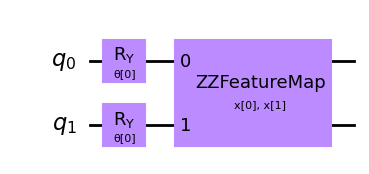

In [13]:
training_params = ParameterVector('θ', 1)

feature_map0 = QuantumCircuit(2)
feature_map0.ry(training_params[0], 0)  # Apply ry rotation with θ0 on qubit 0
feature_map0.ry(training_params[0], 1)  # Apply ry rotation with θ1 on qubit 1

feature_map1 = ZZFeatureMap(2)
feature_map = feature_map0.compose(feature_map1)

feature_map.draw("mpl", style="clifford")

#### Create quantum kernel

In [14]:
quant_kernel = TrainableFidelityQuantumKernel(feature_map=feature_map, training_parameters=training_params)

#### Create optimizer

In [15]:
optimizer = SPSA(
    maxiter=5,
    learning_rate=0.01,
    perturbation=0.05,
    callback=cb_qkt.callback,
)

#### Setup quantum kernel for optimizing

In [16]:
qkt = QuantumKernelTrainer(
        quantum_kernel=quant_kernel,
        loss='svc_loss',
        optimizer=optimizer,
        initial_point=np.random.randn(len(training_params))
    )

#### Optimize quantum kernel

In [17]:
qka_results = qkt.fit(X_train_pca[:100], y_train[:100])

optimized_kernel = qka_results.quantum_kernel

#### Fit the model

In [18]:
qsvc = QSVC(quantum_kernel=optimized_kernel)
qsvc.fit(X_train_pca, y_train)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x165feb970>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

#### Predict on the test and train sets

In [19]:
labels_train = qsvc.predict(X_train_pca)
labels_test = qsvc.predict(X_test_pca)

#### Evaluate the model

In [21]:

accuracy_train = accuracy_score(y_train, labels_train)
rmse_train = np.sqrt(root_mean_squared_error(y_train, labels_train))
conf_matrix_train = confusion_matrix(y_train, labels_train)
class_report_train = classification_report(y_train, labels_train, output_dict=True, zero_division=0)
class_report_df_train = pd.DataFrame(class_report_train).transpose()

print(f"Model Accuracy on Training Data: {accuracy_train * 100:.2f}% \n")
print(f"Root Mean Squared Error (RMSE) on Training Data: {rmse_train:.2f} \n")
print(f"Confusion Matrix on Training Data: \n{conf_matrix_train}\n")
print("Classification Report on Training Data:")
print(class_report_df_train)

Model Accuracy on Training Data: 62.00% 

Root Mean Squared Error (RMSE) on Training Data: 0.79 

Confusion Matrix on Training Data: 
[[ 70 160]
 [ 30 240]]

Classification Report on Training Data:
              precision    recall  f1-score  support
0                 0.700  0.304348  0.424242   230.00
1                 0.600  0.888889  0.716418   270.00
accuracy          0.620  0.620000  0.620000     0.62
macro avg         0.650  0.596618  0.570330   500.00
weighted avg      0.646  0.620000  0.582017   500.00


#### plot precision, recall, and F1-score as bar charts

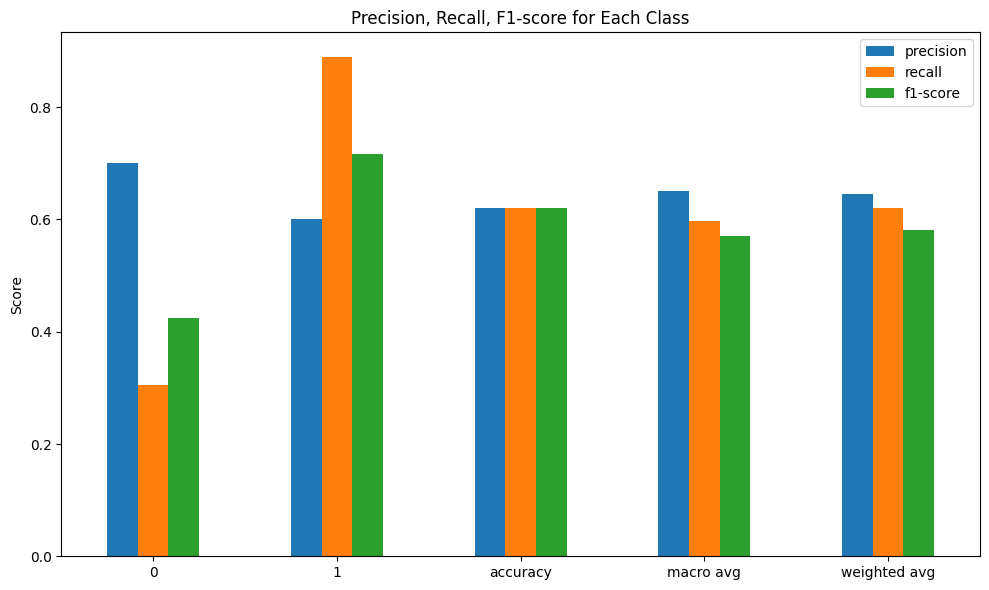

In [22]:
class_report_train = classification_report(y_train, labels_train, output_dict=True, zero_division=0)
metrics_df = pd.DataFrame(class_report_train).transpose()
metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Precision, Recall, F1-score for Each Class')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Cross-validation on training data

In [23]:
cross_val_scores = cross_val_score(qsvc, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation MSE: {cross_val_scores}")

Cross-Validation MSE: [-0.44 -0.41 -0.42 -0.44 -0.47]


#### Plot predicted vs Actual Demand Categories

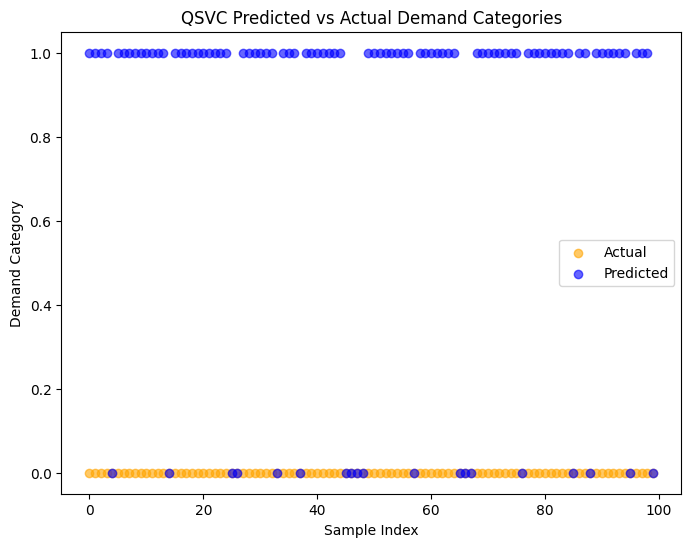

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", color="orange", alpha=0.6)
plt.scatter(range(len(labels_test)), labels_test, label="Predicted", color="blue", alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("Demand Category")
plt.title("QSVC Predicted vs Actual Demand Categories")
plt.legend()
plt.show()

#### Plot the loss

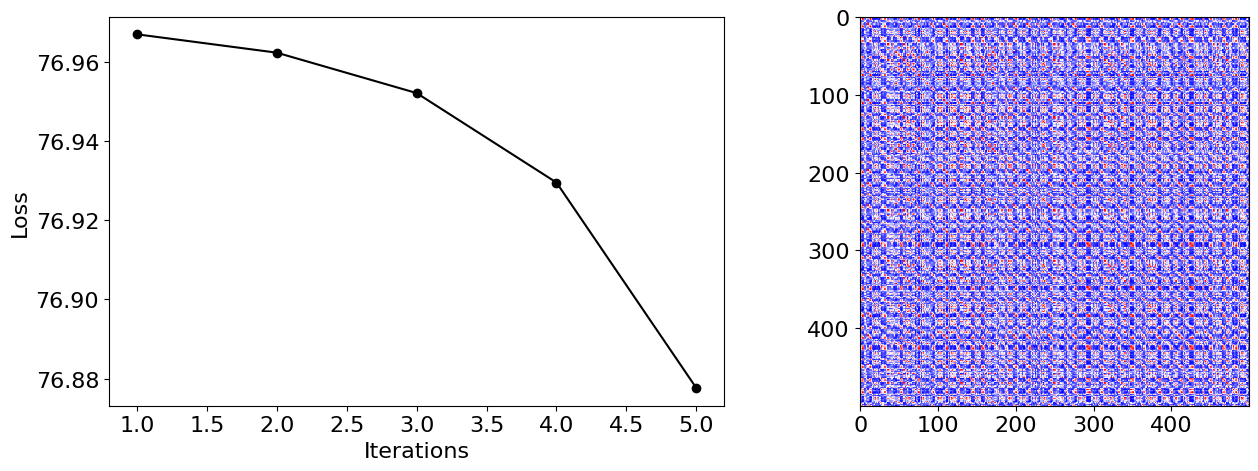

In [25]:
plot_data = cb_qkt.get_callback_data()
K = optimized_kernel.evaluate(X_train_pca)
plt.rcParams["font.size"] = 16
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel ("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=plt.colormaps["bwr"])
fig.tight_layout()
plt.show()

#### Plot the decision boundary (for simplicity, using only one feature)

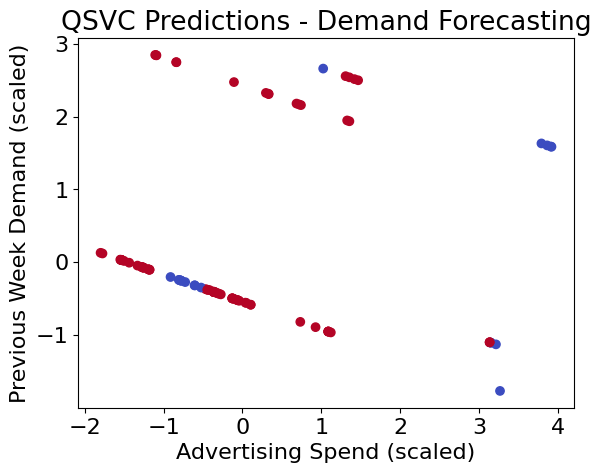

In [26]:
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=labels_test, cmap='coolwarm', marker='o')
plt.xlabel('Advertising Spend (scaled)')
plt.ylabel('Previous Week Demand (scaled)')
plt.title('QSVC Predictions - Demand Forecasting')
plt.show()

#### Trend Analysis

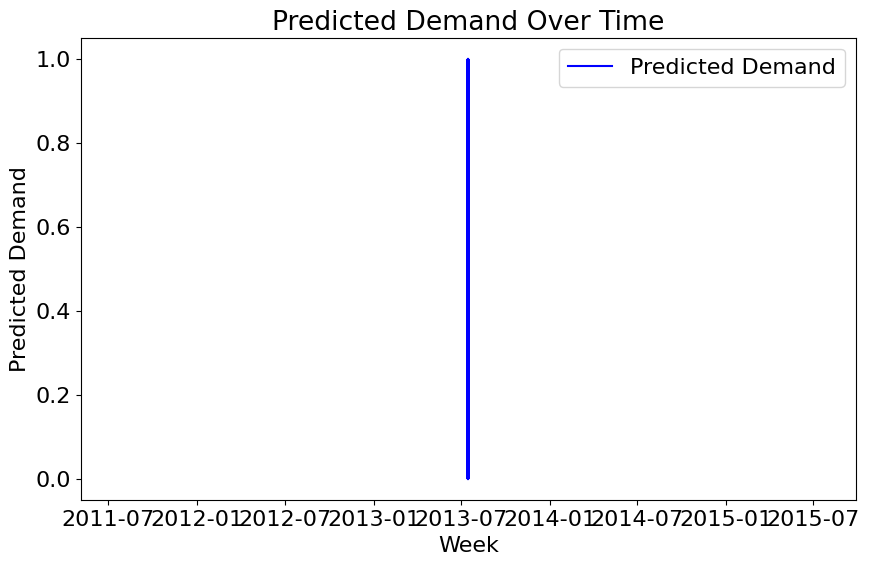

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(test_data_cleaned['week'][:100], labels_test, label="Predicted Demand", color='blue')
plt.xlabel("Week")
plt.ylabel("Predicted Demand")
plt.title("Predicted Demand Over Time")
plt.legend()
plt.show()

#### Plot Confusion Matrix

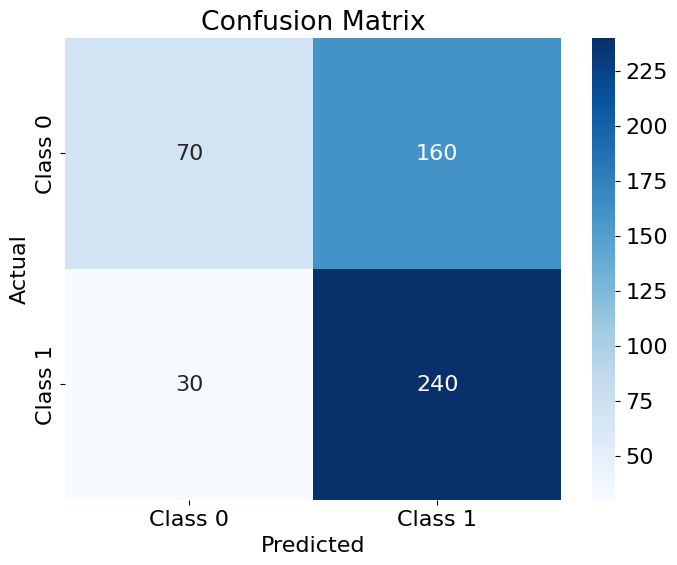

In [29]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Save model

In [30]:
qsvc.save('models/QSVC_demand_forecasting.model')

#### Load model

In [31]:
loaded_model = QSVC.load('models/QSVC_demand_forecasting.model')

#### Test loaded model

In [32]:
train_score = loaded_model.score(X_train_pca[:10], y_train[:10])
test_score = loaded_model.score(X_test_pca[:10], y_test[:10])

print(f"Quantum QSVC on the training dataset: {train_score:.2f}")
print(f"Quantum QSVC on the test dataset: {test_score:.2f}")

Quantum QSVC on the training dataset: 0.60
Quantum QSVC on the test dataset: 0.10


In [33]:
import utils.tutorial_magics
%qiskit_version_table
%qiskit_copyright